In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import scipy.stats as stats
from scipy.signal import savgol_filter

os.chdir('../../')

/Users/Taras_Ustyianovych/workspace/python-envs/climate-discourse-changepoints-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("data/processed/posts_reactions_df_topic_info.parquet")
df["ds"] = pd.to_datetime(df["date"])
df = df.sort_values(by="ds")
df["ds"] = df["ds"].dt.tz_localize(None)

In [3]:
# 1. Calculate the three moving averages
df['init_ma7'] = df['reactions_score'].rolling(window=7, min_periods=1).mean()
df['ma7'] = df['init_ma7'].rolling(window=7, min_periods=1).mean()

df['init_ma15'] = df['reactions_score'].rolling(window=15, min_periods=1).mean()
df['ma15'] = df['init_ma15'].rolling(window=15, min_periods=1).mean()

df['init_ma21'] = df['reactions_score'].rolling(window=21, min_periods=1).mean()
df['ma21'] = df['init_ma21'].rolling(window=21, min_periods=1).mean()

In [4]:
def fit_prophet_and_get_changepoints(data, column='y', n_changepoints=25, 
                                    changepoint_prior_scale=0.05, changepoint_range=0.95, yearly_seasonality=True, weekly_seasonality=True):
    # Prepare dataframe
    prophet_df = data[['ds', column]].rename(columns={column: 'y'})
    
    # Fit model
    model = Prophet(n_changepoints=n_changepoints,
                    changepoint_prior_scale=changepoint_prior_scale,
                    changepoint_range=changepoint_range,
                    yearly_seasonality=yearly_seasonality,
                    weekly_seasonality=weekly_seasonality
                   )
    model.fit(prophet_df)
    
    # Get forecast and extract changepoint information
    future = model.make_future_dataframe(periods=0)  # No forecasting needed
    forecast = model.predict(future)
    
    # Extract changepoints with their magnitudes
    cp_dates = model.changepoints
    cp_effects = model.params['delta'].flatten()
    cp_magnitudes = forecast.loc[forecast['ds'].isin(cp_dates), 'trend'].values
    
    # Create dataframe of changepoints
    changepoints = pd.DataFrame({
        'date': cp_dates,
        'magnitude': np.abs(cp_magnitudes),
        'cp_value': cp_effects
    }).sort_values('cp_value', ascending=False)
    
    return model, changepoints

In [5]:
# Fit models to each smoothed series
_, cp_raw = fit_prophet_and_get_changepoints(df, 'reactions_score')
_, cp_ma7 = fit_prophet_and_get_changepoints(df, 'ma7')
_, cp_ma15 = fit_prophet_and_get_changepoints(df, 'ma15')
_, cp_ma21 = fit_prophet_and_get_changepoints(df, 'ma21')


15:31:29 - cmdstanpy - INFO - Chain [1] start processing
15:31:30 - cmdstanpy - INFO - Chain [1] done processing
15:31:31 - cmdstanpy - INFO - Chain [1] start processing
15:31:31 - cmdstanpy - INFO - Chain [1] done processing
15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing
15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
def jaccard_similarity(cp1, cp2, window_days=3, top_n=30):
    """Calculate Jaccard similarity between two sets of changepoints"""
    cp1_top = cp1['date']
    cp2_top = cp2['date']
    
    # Count matched changepoints
    intersection = 0
    for date1 in cp1_top:
        for date2 in cp2_top:
            if abs((date1 - date2).days) <= window_days:
                intersection += 1
                # print(date1, date2)
                break
    
    # Calculate Jaccard similarity
    union = len(cp1_top) + len(cp2_top) - intersection
    return intersection / union if union > 0 else 0

In [7]:
similarity_matrix = pd.DataFrame(
    index=['Raw', 'MA7', 'MA15', 'MA21'],
    columns=['Raw', 'MA7', 'MA15', 'MA21'],
    data=0.0
)

In [8]:
# Fill similarity matrix
changepoint_sets = {'Raw': cp_raw, 'MA7': cp_ma7, 'MA15': cp_ma15, 'MA21': cp_ma21}
for i in similarity_matrix.index:
    for j in similarity_matrix.columns:
        if i == j:
            similarity_matrix.loc[i, j] = 1.0
        else:
            similarity_matrix.loc[i, j] = jaccard_similarity(
                changepoint_sets[i], changepoint_sets[j])

In [9]:
similarity_matrix

,Raw,MA7,MA15,MA21
Raw,1.0,1.0,1.0,1.0
MA7,1.0,1.0,1.0,1.0
MA15,1.0,1.0,1.0,1.0
MA21,1.0,1.0,1.0,1.0


In [10]:
print("Jaccard Similarity Matrix of Changepoint Sets:")
print(similarity_matrix)


Jaccard Similarity Matrix of Changepoint Sets:
      Raw  MA7  MA15  MA21
Raw   1.0  1.0   1.0   1.0
MA7   1.0  1.0   1.0   1.0
MA15  1.0  1.0   1.0   1.0
MA21  1.0  1.0   1.0   1.0


In [11]:
# Calculate average similarity for each method
avg_similarities = similarity_matrix.mean(axis=1)
print("\nAverage similarity score for each method (higher means more consistent with others):")
print(avg_similarities)


Average similarity score for each method (higher means more consistent with others):
Raw     1.0
MA7     1.0
MA15    1.0
MA21    1.0
dtype: float64


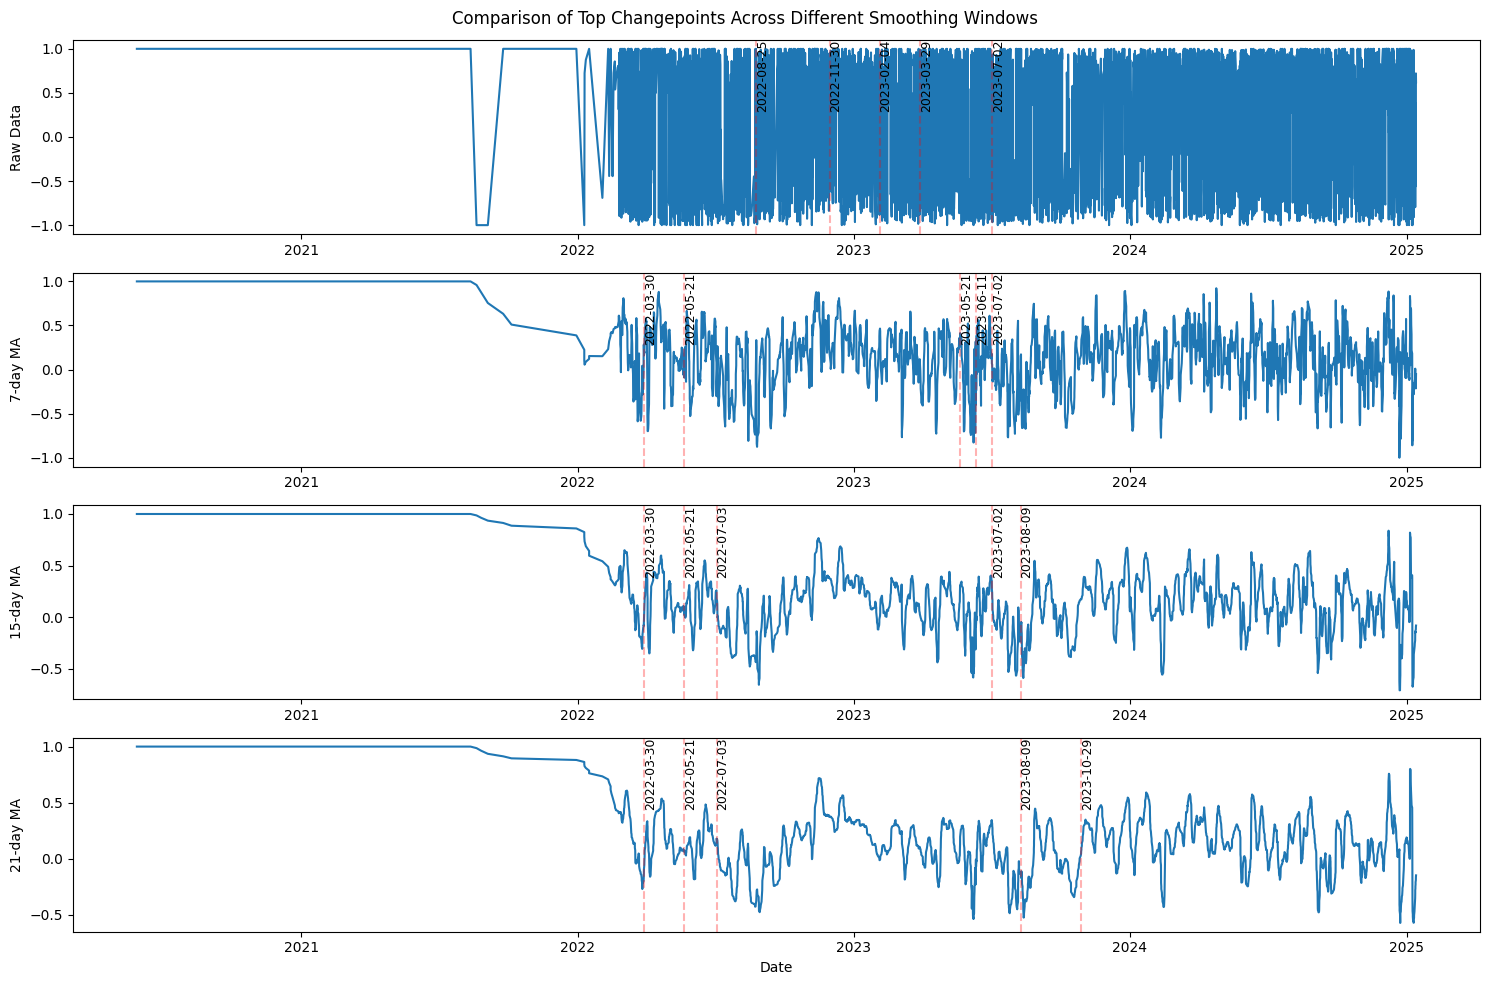

In [12]:
plt.figure(figsize=(15, 10))

# Create subplots for each time series
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2)
ax3 = plt.subplot(4, 1, 3)
ax4 = plt.subplot(4, 1, 4, sharex=ax1)  # Share x-axis with first plot

# Plot each time series with vertical lines for changepoints
for ax, label, data_col, cp_data in [
    (ax1, 'Raw Data', 'reactions_score', cp_raw),
    (ax2, '7-day MA', 'ma7', cp_ma7),
    (ax3, '15-day MA', 'ma15', cp_ma15),
    (ax4, '21-day MA', 'ma21', cp_ma21)
]:
    # Plot the time series
    ax.plot(df['ds'], df[data_col])
    ax.set_ylabel(label)
    
    # Add vertical lines for top 5 changepoints
    for i, row in cp_data.head(5).iterrows():
        ax.axvline(x=row['date'], color='r', linestyle='--', alpha=0.3)
        ax.text(row['date'], ax.get_ylim()[1], f"{row['date'].date()}", 
                rotation=90, verticalalignment='top', fontsize=9)

ax4.set_xlabel('Date')
plt.suptitle('Comparison of Top Changepoints Across Different Smoothing Windows')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [13]:
changepoint_sets_df = pd.concat(changepoint_sets).reset_index()

In [14]:
changepoint_sets_df.date

0    2023-07-02 17:21:41
1    2023-03-29 12:09:00
2    2022-08-25 06:17:38
3    2023-02-04 05:44:59
4    2022-11-30 04:17:37
             ...        
95   2024-05-01 11:23:06
96   2024-09-15 15:58:11
97   2024-06-09 15:10:28
98   2024-07-14 07:34:58
99   2024-08-18 15:52:58
Name: date, Length: 100, dtype: datetime64[ns]

In [15]:
changepoint_sets_df[changepoint_sets_df.date == '2023-07-02 17:21:41']

,level_0,level_1,date,magnitude,cp_value
0,Raw,2243,2023-07-02 17:21:41,0.134471,0.001782
26,MA7,2243,2023-07-02 17:21:41,0.083199,0.247516
54,MA15,2243,2023-07-02 17:21:41,0.074545,0.314637
80,MA21,2243,2023-07-02 17:21:41,0.075489,0.129711


In [16]:
changepoint_sets_df.groupby('level_0').cp_value.mean()

level_0
MA15   -0.023587
MA21   -0.015939
MA7    -0.020382
Raw     0.000074
Name: cp_value, dtype: float64

In [17]:
# Define your known key events
key_events = {
    'Invasion': pd.to_datetime('2022-02-24'),
    'Energy Attack': pd.to_datetime('2022-10-10'),
    'Dam Destruction': pd.to_datetime('2023-06-06')
}

# Check which methods detect each key event
detection_matrix = pd.DataFrame(
    index=key_events.keys(),
    columns=['Raw', 'MA7', 'MA15', 'MA21'],
    data=False
)

In [18]:
detection_matrix

,Raw,MA7,MA15,MA21
Invasion,False,False,False,False
Energy Attack,False,False,False,False
Dam Destruction,False,False,False,False


In [19]:
# Window for considering a changepoint as "detecting" an event (in days)
event_window = 14
for event_name, event_date in key_events.items():
    for method_name, cp_set in changepoint_sets.items():
        top_cp_dates = cp_set.head(10)['date'].values
        detected = any(abs((cp_date - event_date).days) <= event_window 
                     for cp_date in top_cp_dates)
        detection_matrix.loc[event_name, method_name] = detected

print("\nDetection of Key Events by Different Methods:")
print(detection_matrix)


Detection of Key Events by Different Methods:
                   Raw    MA7   MA15   MA21
Invasion         False  False  False  False
Energy Attack     True  False  False  False
Dam Destruction  False   True   True   True


In [20]:
# Calculate consistency score for each event 
# (proportion of methods that detect it)
event_consistency = detection_matrix.mean(axis=1)
print("\nConsistency of event detection across methods:")
print(event_consistency)


Consistency of event detection across methods:
Invasion           0.00
Energy Attack      0.25
Dam Destruction    0.75
dtype: float64


In [21]:
# High threshold for consistency
consistency_threshold = 0.8

# Check if there are drastic shifts (changepoints with high magnitude)
has_drastic_shifts = all(len(cp_set[cp_set['cp_value'] > 
                               np.percentile(cp_set['cp_value'], 75)]) >= 3 
                        for cp_set in changepoint_sets.values())

# Check if shifts remain consistent across different smoothing windows
has_consistent_shifts = (avg_similarities.mean() > consistency_threshold or 
                        event_consistency.mean() > consistency_threshold)

In [22]:
has_consistent_shifts

True

In [23]:
print("\n--- EXPLORATORY HYPOTHESIS EVALUATION ---")
print(f"Evidence for drastic shifts over time: {'STRONG' if has_drastic_shifts else 'WEAK'}")
print(f"Evidence for consistency across smoothing windows: {'STRONG' if has_consistent_shifts else 'WEAK'}")
print(f"Overall conclusion: {'SUPPORT' if has_drastic_shifts and has_consistent_shifts else 'DO NOT SUPPORT'} the exploratory hypothesis")


--- EXPLORATORY HYPOTHESIS EVALUATION ---
Evidence for drastic shifts over time: STRONG
Evidence for consistency across smoothing windows: STRONG
Overall conclusion: SUPPORT the exploratory hypothesis


In [24]:
# Get top 3 changepoints from each method
common_changepoints = {}
for method, cp_set in changepoint_sets.items():
    for _, row in cp_set.iterrows():
        date = row['date']
        magnitude = row['cp_value']
        
        # Check if this date is already in common_changepoints (within window)
        added = False
        for existing_date in list(common_changepoints.keys()):
            if abs((date - existing_date).days) <= event_window:
                common_changepoints[existing_date].append((method, magnitude))
                added = True
                break
        
        if not added:
            common_changepoints[date] = [(method, magnitude)]

In [25]:
# Only keep dates detected by at least 2 methods
consistent_changepoints = {date: methods for date, methods in common_changepoints.items() 
                         if len(methods) >= 2}

print(f"\nFound {len(consistent_changepoints)} consistent changepoints across methods:")


Found 25 consistent changepoints across methods:


In [26]:
for date, methods in consistent_changepoints.items():
    print(f"{date.date()}: Detected by {len(methods)} methods - {[m[0] for m in methods]}")

2023-07-02: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-03-29: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-08-25: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-02-04: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-11-30: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-08-09: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-06-09: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-08-18: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-10-14: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2022-10-16: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-05-21: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-05-01: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-02-08: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2023-06-11: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA21']
2024-07-14: Detected by 4 methods - ['Raw', 'MA7', 'MA15', 'MA

In [27]:
len(consistent_changepoints)

25

In [28]:
consistent_changepoints_df = pd.DataFrame(consistent_changepoints.items())
consistent_changepoints_df.columns = ["date", "methods"]
consistent_changepoints_df["method"] = "reactions_score"
consistent_changepoints_df.to_excel("reactions_score_consistent_changepoints.xlsx", index=False)

In [30]:
date.strftime("%Y-%m-%d")

'2023-10-29'

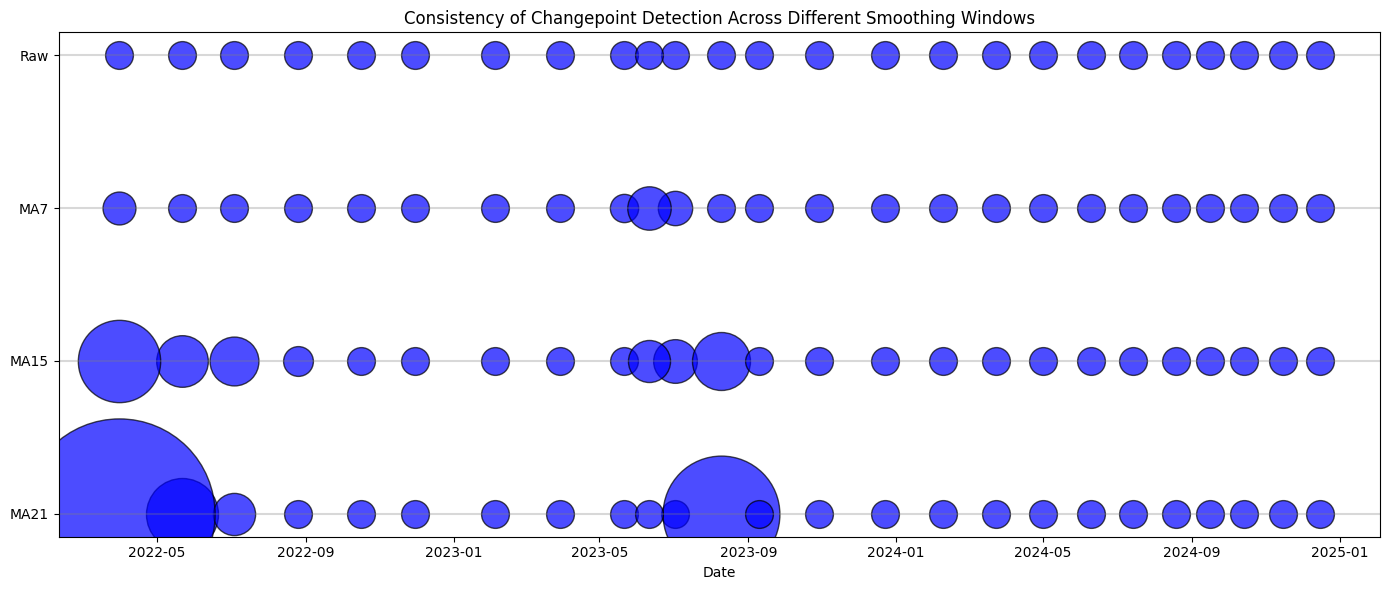

In [31]:
# Create a heatmap visualization of consistent changepoints
plt.figure(figsize=(14, 6))
y_positions = {'Raw': 3, 'MA7': 2, 'MA15': 1, 'MA21': 0}
y_labels = list(y_positions.keys())

# Plot horizontal lines for each method
for method, y_pos in y_positions.items():
    plt.axhline(y=y_pos, color='gray', linestyle='-', alpha=0.3)

# Plot circles for each detection
for date, methods in consistent_changepoints.items():
    for method, magnitude in methods:
        size = max(20, min(500, magnitude * 100))
        plt.scatter(date, y_positions[method], s = size ** 2,
                   alpha=0.7, color='blue', edgecolor='black')

# # Add event markers
# for event_name, event_date in key_events.items():
#     plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.5)
#     plt.text(event_date, 3.5, event_name, rotation=90, 
#             verticalalignment='bottom', horizontalalignment='right')

plt.yticks(list(y_positions.values()), y_labels)
plt.xlabel('Date')
plt.title('Consistency of Changepoint Detection Across Different Smoothing Windows')
plt.tight_layout()
plt.show()